In [2]:
import pandas as pd
from rdkit import Chem

# ---------------------------------------------
# 1) Load your dataset (train or test)
# ---------------------------------------------
df = pd.read_csv("../melting-point-data/test.csv")   # adjust for train.csv if needed

smiles_list = df["SMILES"].tolist()
group_columns = [c for c in df.columns if c.startswith("Group")]

# ---------------------------------------------
# 2) Build a large SMARTS pattern library
# ---------------------------------------------
SMARTS_LIBRARY = {
    "CH3": "[CH3]",
    "CH2": "[CH2]",
    "CH": "[CH]",
    "sp3_C": "[C;X4]",
    "sp2_C": "[C;X3]",
    "sp_C": "[C;X2]",
    "Aromatic_C": "c",
    "Aromatic_N": "n",
    "OH": "[OX2H]",
    "Phenol_OH": "c[OH]",
    "COOH": "C(=O)[OH]",
    "COO": "C(=O)O",
    "Carbonyl": "C=O",
    "Ketone": "C(=O)[C,c]",
    "Aldehyde": "[CX3H](=O)[#6]",
    "Amine_primary": "[NX3H2]",
    "Amine_secondary": "[NX3H][#6]",
    "Amine_tertiary": "[NX3]([#6])([#6])[#6]",
    "Amide": "C(=O)N",
    "Nitrile": "C#N",
    "Alkyne": "C#C",
    "Alkene": "C=C",
    "Ether": "C-O-C",
    "Epoxide": "C1OC1",
    "Halogen_F": "F",
    "Halogen_Cl": "Cl",
    "Halogen_Br": "Br",
    "Halogen_I": "I",
    "Thiol": "S",
    "Sulfoxide": "S(=O)",
    "Sulfone": "S(=O)(=O)",
    "Benzene": "c1ccccc1",
    "Heterocycle_N": "n1cccc1",
    "Heterocycle_O": "o1cccc1",
    "Heterocycle_S": "s1cccc1",
}

# compile patterns
patterns = {name: Chem.MolFromSmarts(smarts) for name, smarts in SMARTS_LIBRARY.items()}

# ---------------------------------------------
# 3) Count SMARTS matches
# ---------------------------------------------
pattern_counts = {name: [] for name in SMARTS_LIBRARY}

for s in smiles_list:
    mol = Chem.MolFromSmiles(s)
    for name, patt in patterns.items():
        if mol is None:
            pattern_counts[name].append(0)
        else:
            pattern_counts[name].append(len(mol.GetSubstructMatches(patt)))

pattern_df = pd.DataFrame(pattern_counts)

# ---------------------------------------------
# 4) Compute correlations of SMARTS vs Group columns
# ---------------------------------------------
# ---------------------------------------------
# 4) Compute correlations of SMARTS vs Group columns (robust)
# ---------------------------------------------
mapping = {}

for group in group_columns:
    group_values = df[group]

    # rohe Korrelation (nicht direkt abs)
    corr = pattern_df.corrwith(group_values)

    # NaNs entfernen
    corr = corr.dropna()

    if corr.empty:
        # kein sinnvolles Matching möglich (z.B. Group-Spalte fast nur Nullen)
        mapping[group] = {
            "best_pattern": None,
            "correlation": None
        }
        continue

    # stärkster Zusammenhang nach Betrag
    best_match = corr.abs().idxmax()
    best_corr = corr[best_match]  # kann positiv oder negativ sein

    mapping[group] = {
        "best_pattern": best_match,
        "correlation": best_corr
    }

mapping_df = pd.DataFrame(mapping).T
mapping_df.to_csv("mapping_table_option_A.csv")
mapping_df.head(20)



/Users/enricofritz/Documents/Melting_point_project/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/enricofritz/Documents/Melting_point_project/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/enricofritz/Documents/Melting_point_project/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/enricofritz/Documents/Melting_point_project/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/enricofritz/Documents/Melting_point_project/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


,best_pattern,correlation
Group 1,CH3,0.915379
Group 2,CH2,0.923681
Group 3,CH,0.394394
Group 4,CH3,0.434955
Group 5,Alkene,0.553612
Group 6,Alkene,0.343208
Group 7,Alkene,0.456371
Group 8,Alkene,0.375818
Group 9,Halogen_Br,0.163453
Group 10,None,None


In [ ]:
df[["SMILES","Group 1"]].head(20)

In [ ]:
mapping_df.sort_values([ 'correlation'], ascending=False).head(10)

,best_pattern,correlation
Group 30,Phenol_OH,0.985509
Group 31,COOH,0.969838
Group 2,CH2,0.923681
Group 1,CH3,0.915379
Group 15,Aromatic_C,0.897967
Group 127,Halogen_I,0.856022
Group 13,Alkyne,0.824499
Group 149,Sulfone,0.815882
Group 128,Halogen_Br,0.792061
Group 62,Amine_primary,0.764617


In [ ]:
import numpy as np

a = np.array([mapping_df.head(1)])


a.shape
a

array([[['CH3', np.float64(0.9153789128025311)]]], dtype=object)

In [ ]:
df.loc[df['Group 1'] > 0 , ['SMILES', 'Group 1']].head(20)



,SMILES,Group 1
0,CCOC(=O)c1ccc(O)cc1,1
1,CCCCCCc1ccc(O)cc1O,1
3,C=CCCCCCCCC,1
5,CCCCCCCCCCCCCCCCCCCCCCCCCCCCC,2
6,CCCC(=O)OCC(COC(=O)CCC)OC(=O)CCC,3
8,CCCCCC(=O)CCCCC,2
9,CCOC(=O)CC(=O)C,1
11,CCCC(C)(CO)CO,2
15,CCCCCCCCCCCCCCC(=O)O,1
16,CCOC(=O)CCCCCCCCC(=O)OCC,2


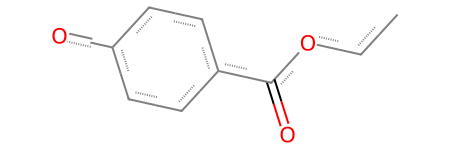

In [ ]:
SMARTS_LIBRARY["CH3"]
pattern_counts['CH3']
Chem.MolFromSmarts("CCOC(=O)c1ccc(O)cc1")



In [ ]:
group_cols = df.filter(like="Group").columns
df_filtered = df[df[group_cols].gt(0).any(axis=1)]
df_filtered[['SMILES'] + list(group_cols)].head(20)

df[['SMILES'] + list(group_cols)].where(df[group_cols] > 0)


df.loc[df['Group 1'] > 0, group_cols]

# group_cols.append("SMILES")

,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,Group 8,Group 9,Group 10,...,Group 415,Group 416,Group 417,Group 418,Group 419,Group 420,Group 421,Group 422,Group 423,Group 424
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,7,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2,27,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,3,5,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,3,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
661,2,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
662,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
663,2,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
group_cols = df.filter(like="Group").columns

df[group_cols].where(df[group_cols] > 0)

group_cols = df.filter(like="Group").columns

df["positive_groups"] = df[group_cols].apply(
    lambda row: row[row > 0].index.tolist(),
    axis=1
)


,SMILES,positive_groups
0,CCOC(=O)c1ccc(O)cc1,"[Group 1, Group 2, Group 15, Group 30, Group 4..."
1,CCCCCCc1ccc(O)cc1O,"[Group 1, Group 2, Group 15, Group 21, Group 3..."
2,ClCBr,"[Group 108, Group 128]"
3,C=CCCCCCCCC,"[Group 1, Group 2, Group 5, Group 228]"
4,Fc1ccc(cc1)C(F)(F)F,"[Group 15, Group 23, Group 124, Group 129, Gro..."
5,CCCCCCCCCCCCCCCCCCCCCCCCCCCCC,"[Group 1, Group 2]"
6,CCCC(=O)OCC(COC(=O)CCC)OC(=O)CCC,"[Group 1, Group 2, Group 3, Group 41, Group 257]"
7,O=C(Cl)c1cccc(c1)C(=O)Cl,"[Group 15, Group 37, Group 130, Group 325]"
8,CCCCCC(=O)CCCCC,"[Group 1, Group 2, Group 34]"
9,CCOC(=O)CC(=O)C,"[Group 1, Group 2, Group 33, Group 41, Group 2..."


In [ ]:
import numpy as np

group_cols = df.filter(like="Group").columns

cols_row0 = df.loc[0, group_cols][df.loc[0, group_cols] > 0].index.tolist()
print(cols_row0)

cols_row0.insert(0,'SMILES')
df[cols_row0].head(1)

   




['Group 1', 'Group 2', 'Group 15', 'Group 30', 'Group 45', 'Group 326']


,SMILES,Group 1,Group 2,Group 15,Group 30,Group 45,Group 326
0,CCOC(=O)c1ccc(O)cc1,1,1,4,1,1,1
